<a href="https://colab.research.google.com/github/bandofpv/Handwritten_Text/blob/master/src/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Text 

This tutorial shows how to train a Handwritten Text recognition model in your Google Colab. View the full tutorial [here](https://www.hackster.io/bandofpv/reading-eye-for-the-blind-with-jetson-nano-tensorflow-8657ed)



## 1 Google Drive Environment


### 1.1 TensorFlow 2.0

Make sure the jupyter notebook is using GPU mode.

In [0]:
!nvidia-smi

Thu Feb  6 02:42:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Now, we'll install TensorFlow 2.0 with GPU support.

In [0]:
!pip install -q tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 450kB 59.0MB/s 
     |████████████████████████████████| 3.8MB 63.7MB/s 
     |████████████████████████████████| 81kB 13.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.


In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


### 1.2 Google Drive

Mount your Google Drive partition.

**Note:** *\"Colab Notebooks/handwritten-text/src/\"* was the directory where you put the project folders, specifically the **src** folder.

In [0]:
from google.colab import drive

drive.mount("./gdrive", force_remount=True)

%cd "./gdrive/My Drive/Colab Notebooks/handwritten-text-recognition/src/"
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/handwritten-text-recognition/src
total 37
drwx------ 2 root root  4096 Feb  5 06:08 data
-rw------- 1 root root 11560 Feb  5 06:08 main.py
drwx------ 2 root root  4096 Feb  5 06:08 network
-rw------- 1 root root 17914 Feb  5 06:08 tutorial.ipynb


After mount, you can see the list os files in the project folder.

## 2 Set Python Classes

### 2.1 Environment

First, let's define our environment variables.

Set the main configuration parameters, like input size, batch size, number of epochs and list of characters your liking or keep the default parameters. 

* **dataset**: "bentham", "iam", "rimes", "saintgall", "washington"

* **arch**: network to run: "bluche", "puigcerver", "flor"

* **epochs**: number of epochs

* **batch_size**: number size of the batch

In [0]:
import os
import datetime
import string

# define parameters
source = "iam"
arch = "flor"
epochs = 1000
batch_size = 16

# define paths
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/iam.hdf5
output ../output/iam/flor
target ../output/iam/flor/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


### 2.2 DataGenerator Class

The second class is **DataGenerator()**, responsible for:

* Load the dataset partitions (train, valid, test);

* Manager batchs for train/validation/test process.

In [0]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 5369
Validation images: 744
Test images: 1425


### 2.3 HTRModel Class

The third class is **HTRModel()**, was developed to be easy to use and to abstract the complicated flow of a HTR system. It's responsible for:

* Create model with Handwritten Text Recognition flow, in which calculate the loss function by CTC and decode output to calculate the HTR metrics (CER, WER and SER);

* Save and load model;

* Load weights in the models (train/infer);

* Make Train/Predict process using *generator*.

To make a dynamic HTRModel, its parameters are the *architecture*, *input_size* and *vocab_size*.

In [0]:
from network.model import HTRModel

# create and compile HTRModel
# note: `learning_rate=None` will get architecture default value
model = HTRModel(architecture=arch, input_size=input_size, vocab_size=dtgen.tokenizer.vocab_size)
model.compile(learning_rate=0.001)

# save network summary
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024, 128, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 64, 16)       160       
_________________________________________________________________
p_re_lu (PReLU)              (None, 512, 64, 16)       16        
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 64, 16)       112       
_________________________________________________________________
full_gated_conv2d (FullGated (None, 512, 64, 16)       4640      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 64, 32)       4640      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 512, 64, 32)       32    

## 3 Training

The training process is similar to the *fit()* of the Keras. After training, the information (epochs and minimum loss) is save.

In [0]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Train for 336 steps, validate for 47 steps
Epoch 1/1000
335/336 [============================>.] - ETA: 0s - loss: 137.9633
Epoch 00001: val_loss improved from inf to 123.13102, saving model to ../output/iam/flor/checkpoint_weights.hdf5
336/336 [==============================] - 87s 260ms/step - loss: 137.8443 - val_loss: 123.1310
Epoch 2/1000
335/336 [============================>.] - ETA: 0s - loss: 94.2353
Epoch 00002: val_loss improved from 123.13102 to 81.93496, saving model to ../output/iam/flor/checkpoint_weights.hdf5
336/336 [==============================] - 69s 206ms/step - loss: 94.1436 - val_loss: 81.9350
Epoch 3/1000
335/336 [============================>.] - ETA: 0s - loss: 68.6377
Epoch 00003: val_loss improved from 81.93496 to 60.04024, saving model to ../output/iam/flor/checkpoint_weights.hdf5
336/336 [==============================] - 70s 208ms/step - loss: 68.5289 - val_loss: 60.0402
Epoch 4/1000
335/336 [============================>.] - ETA: 0s - loss: 51.5287
Epoc

## 4 Predict

The predict process is similar to the *predict* of the Keras:

Model Predict
90/90 [==============================] - 6s 63ms/step
CTC Decode
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
90/90 [==============================] - 61s 683ms/step



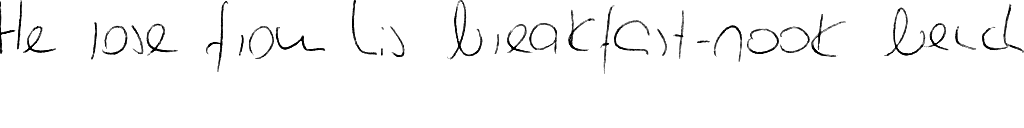

He rose from his breakfast - nook bench
He lose from his breakfait - not bench 




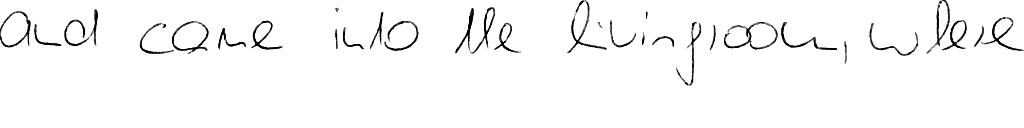

and came into the livingroom , where
and came into the livingion , where 




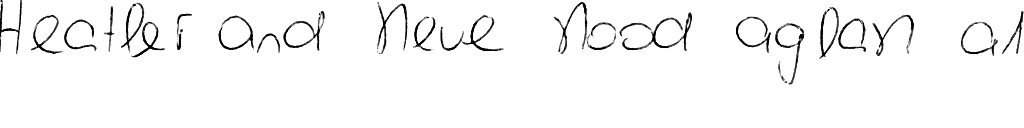

Heather and Steve stood aghast at
Heatler and Meve Nod aglan at 




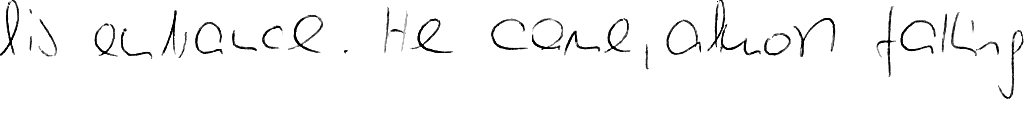

his entrance . He came , almost falling
lis entiance . He came , almon faling 




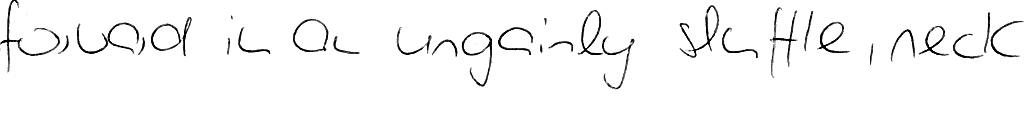

forward in an ungainly shuffle , neck
frvad in On ungainly slutle , neck 




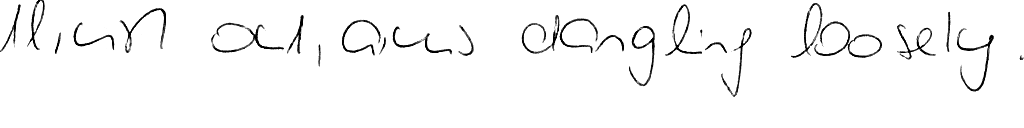

thrust out , arms dangling loosely .
Aliw ocd , ans dangling losely . 




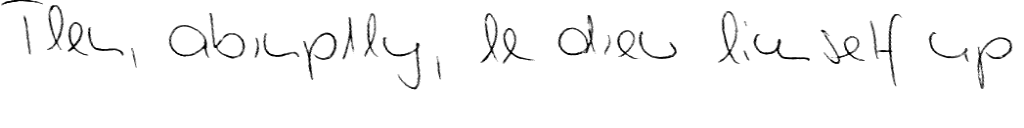

Then , abruptly , he drew himself up
Tlen , abmply , le odiev limself up 




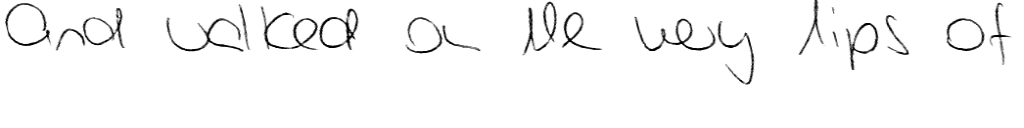

and walked on the very tips of
And valked on te very lips of 




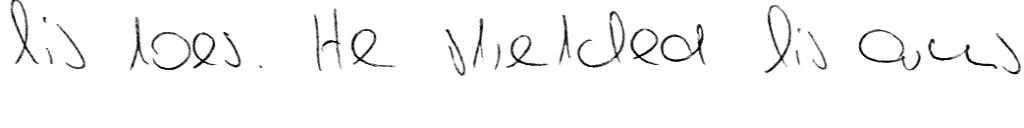

his toes . He stretched his arms
Ris 1oes . He stelcled lis ovens 




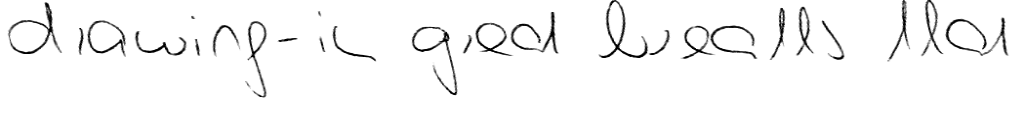

drawing - in great breaths that
drawing - in gread brsals 1l0 



In [0]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, dtgen.dataset['test']['gt']):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print(dtgen.dataset['test']['gt'][i])
    print(predicts[i], "\n")

The top sentence is the actual text and the bottom sentence is the predicted text.

## 5 Evaluate

Evaluation process is more manual process. Here we have the `ocr_metrics`, but feel free to implement other metrics instead. In the function, we have three parameters: 

* predicts
* ground_truth
* norm_accentuation (calculation with/without accentuation)
* norm_punctuation (calculation with/without punctuation marks)

In [0]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=dtgen.dataset['test']['gt'],
                                  norm_accentuation=False,
                                  norm_punctuation=False)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    1425
Total time:           0:01:07.633403
Time per item:        0:00:00.047462

Metrics:
Character Error Rate: 0.07405119
Word Error Rate:      0.24940606
Sequence Error Rate:  0.90877193
